# Calculate Search Metrics with Dynamic Optimizer

This notebook loads the models that were built in the previous notebook and test how much the queries improve when using a pipeline with the predicted "neuralness" value.

1. Get the models
2. Get the queries
3. Get the ratings file
4. Get the predicted "neuralness" scores for each query from each model
5. Run the queries (two runs per query; one per model)
    1. Create the pipeline with the according "neuralness" and "keywordness" values
    2. Run the query once per model type
    3. Store the results
7. Calculate search metrics
8. Compare search metrics with the best metrics of the notebook that explored all hybrid search configurations 

In [339]:
import pickle
import pandas as pd
import requests
import json
import uuid
import numpy as np
import plotly.express as px

## Load models from the previous notebook

In [340]:
# load the two models
with open('regression_model.pkl', 'rb') as fid:
    regr = pickle.load(fid)

with open('random_forest_model.pkl', 'rb') as fid:
    random_forest = pickle.load(fid)

In [341]:
# Import the ratings generated in the previous notebook
df_ratings = pd.read_csv('ratings.csv', sep="\t", names=['query', 'docid', 'rating', 'idx'])#, index=False)
df_ratings.head(5)

,query,docid,rating,idx
0,$30 roblox gift card not digital,B07RX6FBFR,3,0
1,$30 roblox gift card not digital,B09194H44R,0,0
2,$30 roblox gift card not digital,B08R5N6W6B,2,0
3,$30 roblox gift card not digital,B07Y693ND1,0,0
4,$30 roblox gift card not digital,B07RZ75JW3,2,0


In [342]:
df_test_data = pd.read_csv('dynamic_optimizer_test_data.csv')

In [343]:
df_test_data.head(5)

,query_string,ndcg,neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
0,7 days without a pun makes one weak,0.664066,1.0,8,35,1,0,13,0.261906,2.187382,0.816212,0.714292
1,american flag 5x8 outdoor made in usa,0.595807,0.3,7,37,1,0,8,0.913549,4.974668,0.755891,0.723251
2,andis t edger,0.308602,1.0,3,13,0,0,2,0.086820,0.166090,0.578003,0.519416
3,backpacks lunchbox combo,0.084726,1.0,3,24,0,0,6,0.721674,1.747816,0.731043,0.656633
4,best ride on cars mercedes 3-in-1 push car in ...,0.426893,0.9,10,51,1,1,1,0.784587,0.784587,0.868892,0.631813


In [344]:
df_test_data.shape[0]

44

## Predict the "neuralness" with both models

In [345]:
feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
def get_linear_model_prediction(row):
    df_row = pd.DataFrame([row[feature_columns]], columns=feature_columns)
    return regr.predict(df_row)[0]

def get_random_forest_prediction(row):
    df_row = pd.DataFrame([row[feature_columns]], columns=feature_columns)
    return random_forest.predict(df_row)[0]

In [346]:
# make predictions with the two models ensuring that the minimum is not below 0 and the maximum not above 1

df_test_data['linear_model'] = df_test_data.apply(
    lambda row: min(np.max(get_linear_model_prediction(row), 0), 1), axis=1
)

df_test_data['random_forest'] = df_test_data.apply(
    lambda row: min(np.max(get_random_forest_prediction(row), 0), 1), axis=1
)

In [347]:
df_test_data.head(5)

,query_string,ndcg,neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score,linear_model,random_forest
0,7 days without a pun makes one weak,0.664066,1.0,8,35,1,0,13,0.261906,2.187382,0.816212,0.714292,0.801477,0.435
1,american flag 5x8 outdoor made in usa,0.595807,0.3,7,37,1,0,8,0.913549,4.974668,0.755891,0.723251,0.741743,0.516
2,andis t edger,0.308602,1.0,3,13,0,0,2,0.086820,0.166090,0.578003,0.519416,0.735459,0.669
3,backpacks lunchbox combo,0.084726,1.0,3,24,0,0,6,0.721674,1.747816,0.731043,0.656633,0.780726,0.774
4,best ride on cars mercedes 3-in-1 push car in ...,0.426893,0.9,10,51,1,1,1,0.784587,0.784587,0.868892,0.631813,0.685039,0.609


## Run the queries of the test set

* Retrieve the model id
* For each query term of the test set:
  * Create the pipeline with the predicted "neuralness" value and the calculated "keywordness" value (`1-"neuralness"`)
  * Run the query once per model type

In [348]:
# Get model_id
# We are assuming that the installation has only one model. Change this if you have more models 
# and need to pick a specific one

headers = {
    'Content-Type': 'application/json'
}

def get_model_id():
    url = "http://localhost:9200/_plugins/_ml/models/_search"
   
    payload = {
      "query": {
        "match_all": {}
      },
      "size": 1
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))

    return response.json()['hits']['hits'][0]['_source']['model_id']

model_id = get_model_id()

In [296]:
# The function receives a float for the "neuralness" of a query
# The pipeline is created with a generated UUID
# The generated UUID is returned so that it can be used for the query.

def create_search_pipeline(neuralness):
    neuralness = round(neuralness, 2)
    keywordness = 1 - neuralness

    # create a pipeline id on the fly. We return it to the function that calls this function
    pipeline_name = uuid.uuid4().hex[:8]


    payload = {
      "request_processors": [
        {
          "neural_query_enricher" : {
            "description": "one of many search pipelines for experimentation",
            "default_model_id": model_id,
            "neural_field_default_id": {
               "title_embeddings": model_id
            }
          }
        }
      ],
      "phase_results_processors": [
        {
          "normalization-processor": {
            "normalization": {
              "technique": "l2"
            },
            "combination": {
              "technique": "arithmetic_mean",
              "parameters": {
                "weights": [
                  keywordness,
                  neuralness
                ]
              }
            }
          }
        }
      ]    
    }

    url = "http://localhost:9200/_search/pipeline/" + pipeline_name
    
    response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
    #print(payload)
    
    return pipeline_name

In [402]:
models = ['linear_model', 'random_forest']
df_relevance = pd.DataFrame()

# iterate over all query strings, create a pipeline with the predicted "neuralness"
# and send a hybrid search query to OpenSearch with the set pipeline
for query in df_test_data.itertuples():
    for model in models:
        neuralness = df_test_data.loc[df_test_data['query_string'] == query[1], model].iloc[0]
        neuralness = round(neuralness, 2)
        keywordness = 1 - neuralness   
        #pipeline_name = create_search_pipeline(neuralness)
       # print(pipeline_name)
        # Set pipeline 
        url = "http://localhost:9200/ecommerce/_search"

    
        payload = {
          "_source": {
            "excludes": [
              "title_embedding"
            ]
          },
          "query": {
            "hybrid": {
              "queries": [
                {
                  "multi_match" : {
                      "type":       "best_fields",
                      "fields":     [
                        "product_id^100",
                        "product_bullet_point^3",
                        "product_color^2",
                        "product_brand^5",
                        "product_description",
                        "product_title^10"
                      ],
                      "operator":   "and",
                      "query":      query[1]
                    }
                },
                {
                  "neural": {
                    "title_embedding": {
                      "query_text": query[1],
                      "k": 100
                    }
                  }
                }
              ]
            }
          },
            "search_pipeline": {
              "request_processors": [
                {
                  "neural_query_enricher" : {
                    "description": "one of many search pipelines for experimentation",
                    "default_model_id": model_id,
                    "neural_field_default_id": {
                       "title_embeddings": model_id
                    }
                  }
                }
              ],
              "phase_results_processors": [
                {
                  "normalization-processor": {
                    "normalization": {
                      "technique": "l2"
                    },
                    "combination": {
                      "technique": "arithmetic_mean",
                      "parameters": {
                        "weights": [
                          keywordness,
                          neuralness
                        ]
                      }
                    }
                  }
                }
              ]    
            },
          "size": 100
        }
    
        response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
        #print(response)
        # store results per model and pipeline
        position = 0
        for hit in response['hits']['hits']:
            # create a new row for the DataFrame and append it
            row = { 'query_id' : str(query[0]), 'query_string': query[1], 'product_id' : hit["_id"], 'position' : str(position), 'relevance' : hit["_score"], 'run': model, 'neuralness': neuralness }
    
            new_row_df = pd.DataFrame([row])
            df_relevance = pd.concat([df_relevance, new_row_df], ignore_index=True)
            position += 1
    
    # work with two for loops:
    # 1) one to iterate over the list of queries and have a query id instead of a query
    # 2) another one to iterate over the result sets to have the position of the result in the result set 
    
    # DataFrame is created using some of TREC's namings for the evaluation tools:
    # query_id: the id of the query as the trec_eval tool needs a numeric id rather than a query string as an identifier
    # query_string: the user query
    # product_id: the id of the product in the hit list
    # position: the position of the product in the result set
    # relevance: relevance as given by the search engine
    # run: the name of the model used to predict the neuralness of the model
    # pipeline: the pipeline used for the query

In [403]:
# we have number of queries * number of models * 100 retrieved results in the resulting DataFrame
df_relevance.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness
0,0,7 days without a pun makes one weak,B07PCLLG2H,0,0.358882,linear_model,0.8
1,0,7 days without a pun makes one weak,B07PY9SL52,1,0.352712,linear_model,0.8
2,0,7 days without a pun makes one weak,B083Z9M4TR,2,0.347025,linear_model,0.8


In [405]:
df_ratings.head(3)

,query_string,product_id,rating,query_id
0,$30 roblox gift card not digital,B07RX6FBFR,3,0
1,$30 roblox gift card not digital,B09194H44R,0,0
2,$30 roblox gift card not digital,B08R5N6W6B,2,0


In [406]:
df_ratings.columns = ['query_string', 'product_id', 'rating', 'query_id']
df_ratings.head(3)

,query_string,product_id,rating,query_id
0,$30 roblox gift card not digital,B07RX6FBFR,3,0
1,$30 roblox gift card not digital,B09194H44R,0,0
2,$30 roblox gift card not digital,B08R5N6W6B,2,0


In [407]:
df_relevance.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness
0,0,7 days without a pun makes one weak,B07PCLLG2H,0,0.358882,linear_model,0.8
1,0,7 days without a pun makes one weak,B07PY9SL52,1,0.352712,linear_model,0.8
2,0,7 days without a pun makes one weak,B083Z9M4TR,2,0.347025,linear_model,0.8


In [408]:
# Make sure ids are strings - otherwise the merge operation might cause an error
df_relevance['query_id'] = df_relevance['query_id'].astype(str)
df_relevance['position'] = df_relevance['position'].astype(int)
df_ratings['query_id'] = df_ratings['query_id'].astype(str)
# Remove duplicates from the ratings DataFrame
df_unique_ratings = df_ratings.drop_duplicates(subset=['product_id', 'query_id'])

In [409]:
# Merge results on query_string and product_id so that the resulting DataFrame has the ratings together with the search results
# Merge on query_string instead of query_id because the df_relevance query_ids are not the ones originating from the ratings.
# Validations helps us make sure that we have only one rating for each query-doc pair. We have identical query-doc pairs per
# search pipeline but we can only have one rating for these.

df_merged = df_relevance.merge(df_unique_ratings, on=['query_string', 'product_id'], how='left', validate='many_to_one')
# remove unnecessary information and rename columns
df_merged = df_merged.drop(columns=['query_id_y'])

df_merged = df_merged.rename(columns={"query_id_x": "query_id"})
df_merged.head(3)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,7 days without a pun makes one weak,B07PCLLG2H,0,0.358882,linear_model,0.8,3.0
1,0,7 days without a pun makes one weak,B07PY9SL52,1,0.352712,linear_model,0.8,NaN
2,0,7 days without a pun makes one weak,B083Z9M4TR,2,0.347025,linear_model,0.8,3.0


In [410]:
# Count the rows without ratings - the higher the count is the less reliable the results will be
nan_count_rating = df_merged['rating'].isna().sum()
print(f"There are {df_merged.shape[0]} rows and {nan_count_rating} do not contain a rating among the 100 returned results per query")
nan_count_rating_top_10 = df_merged[df_merged['position'] < 10]['rating'].isna().sum()
print(f"{nan_count_rating_top_10} do not contain a rating among the top 10 returned results per query")

There are 880 rows and 586 do not contain a rating among the 100 returned results per query
586 do not contain a rating among the top 10 returned results per query


In [397]:
df_merged[df_merged['position'] < 10].head(10)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,7 days without a pun makes one weak,B07PCLLG2H,0,0.193235,linear_model,0.8,3.0
1,0,7 days without a pun makes one weak,B07PY9SL52,1,0.190547,linear_model,0.8,NaN
2,0,7 days without a pun makes one weak,B083Z9M4TR,2,0.186959,linear_model,0.8,3.0
3,0,7 days without a pun makes one weak,B07PGBYSYD,3,0.184747,linear_model,0.8,3.0
4,0,7 days without a pun makes one weak,B07RHGP8T8,4,0.181853,linear_model,0.8,3.0
5,0,7 days without a pun makes one weak,B07SQQX2MM,5,0.168095,linear_model,0.8,3.0
6,0,7 days without a pun makes one weak,B098DQCZRN,6,0.157232,linear_model,0.8,3.0
7,0,7 days without a pun makes one weak,B07BGXLBVF,7,0.140699,linear_model,0.8,3.0
8,0,7 days without a pun makes one weak,B086JPN89N,8,0.138292,linear_model,0.8,3.0
9,0,7 days without a pun makes one weak,1687430438,9,0.136704,linear_model,0.8,3.0


In [ ]:
# import from shared utils file metrics.py
from utils import metrics

metrics = [
    ("dcg", metrics.dcg_at_10, None),
    ("ndcg", metrics.ndcg_at_10, None),
    ("prec@10", metrics.precision_at_k, None),
    ("ratio_of_ratings", metrics.ratio_of_ratings, None)
]

In [398]:
reference = {query: df for query, df in df_ratings.groupby("query_string")}

df_metrics = []
for m_name, m_function, ref_search in metrics:
    for (query_string, run), df_gr in df_merged.groupby(["query_string", "run"]):
        metric = m_function(df_gr, reference=reference[query_string])
        df_metrics.append(pd.DataFrame({
            "query": [query_string],
            "model": [run],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics = pd.concat(df_metrics)

In [399]:
df_metrics.head(3)

,query,model,metric,value
0,7 days without a pun makes one weak,linear_model,dcg,15.650518
0,7 days without a pun makes one weak,random_forest,dcg,15.650518
0,american flag 5x8 outdoor made in usa,linear_model,dcg,13.218665


In [400]:
df_merged[(df_merged['query_string'] == '7 days without a pun makes one weak') & (df_merged['run'] == 'linear_model')].head(10)

,query_id,query_string,product_id,position,relevance,run,neuralness,rating
0,0,7 days without a pun makes one weak,B07PCLLG2H,0,0.193235,linear_model,0.8,3.0
1,0,7 days without a pun makes one weak,B07PY9SL52,1,0.190547,linear_model,0.8,NaN
2,0,7 days without a pun makes one weak,B083Z9M4TR,2,0.186959,linear_model,0.8,3.0
3,0,7 days without a pun makes one weak,B07PGBYSYD,3,0.184747,linear_model,0.8,3.0
4,0,7 days without a pun makes one weak,B07RHGP8T8,4,0.181853,linear_model,0.8,3.0
5,0,7 days without a pun makes one weak,B07SQQX2MM,5,0.168095,linear_model,0.8,3.0
6,0,7 days without a pun makes one weak,B098DQCZRN,6,0.157232,linear_model,0.8,3.0
7,0,7 days without a pun makes one weak,B07BGXLBVF,7,0.140699,linear_model,0.8,3.0
8,0,7 days without a pun makes one weak,B086JPN89N,8,0.138292,linear_model,0.8,3.0
9,0,7 days without a pun makes one weak,1687430438,9,0.136704,linear_model,0.8,3.0


## Calculate Metrics per Model by Averaging the Query Metrics

In [424]:
df_metrics_per_pipeline = df_metrics.pivot_table(index="model", columns="metric", values="value", aggfunc=lambda x: x.mean().round(2))
df_metrics_per_pipeline = df_metrics_per_pipeline.reset_index()
df_metrics_per_pipeline

metric,model,dcg,ndcg,prec@10,ratio_of_ratings
0,linear_model,7.57,0.35,0.39,0.41
1,random_forest,7.82,0.36,0.41,0.43


In [374]:
df_global_optimization_metrics = pd.read_csv('metrics.csv')
df_global_optimization_metrics.head(3)

,query,pipeline,metric,value
0,$30 roblox gift card not digital,l2arithmetic_mean0.0,dcg,0.84477
1,$30 roblox gift card not digital,l2arithmetic_mean0.1,dcg,0.84477
2,$30 roblox gift card not digital,l2arithmetic_mean0.2,dcg,0.84477


In [375]:
df_metrics_pivot = df_metrics.pivot_table(index="query", columns=["model", "metric"], values="value").reset_index()
df_metrics_pivot.columns = [" ".join(c).strip() for c in df_metrics_pivot.columns.values]
df_metrics_pivot.head(3)

,query,linear_model dcg,linear_model ndcg,linear_model prec@10,linear_model ratio_of_ratings,random_forest dcg,random_forest ndcg,random_forest prec@10,random_forest ratio_of_ratings
0,7 days without a pun makes one weak,15.650518,0.664066,0.9,0.9,15.650518,0.664066,0.9,0.9
1,american flag 5x8 outdoor made in usa,8.523719,0.348990,0.3,0.3,11.793836,0.482879,0.5,0.5
2,andis t edger,6.000000,0.283828,0.2,0.2,6.000000,0.283828,0.2,0.2


## Get the max metric values to compare the per-query optimization approach to

In [376]:
metrics = ['dcg', 'ndcg', 'prec@10']
print("Max metrics for the query \'$30 roblox gift card not digital\'")
for metric in metrics:
    max_value = df_global_optimization_metrics[(df_global_optimization_metrics['query'] == '$30 roblox gift card not digital') & (df_global_optimization_metrics['metric'] == metric)]['value'].max()
    print(f"max for {metric}: {max_value}")

Max metrics for the query '$30 roblox gift card not digital'
max for dcg: 0.8447702602206777
max for ndcg: 0.0757673225293483
max for prec@10: 0.1


In [377]:
df_global_optimization_metrics_gr = df_global_optimization_metrics.groupby(by=['query', 'metric']).agg({
    'value': 'max'
}).reset_index()
df_global_optimization_metrics_gr[df_global_optimization_metrics_gr['query'] == '$30 roblox gift card not digital']

,query,metric,value
0,$30 roblox gift card not digital,dcg,0.844770
1,$30 roblox gift card not digital,dcg_dense,5.908355
2,$30 roblox gift card not digital,ndcg,0.075767
3,$30 roblox gift card not digital,prec@10,0.100000
4,$30 roblox gift card not digital,ratio_of_ratings,0.200000


In [378]:
df_global_optimization_metrics_pivot = df_global_optimization_metrics_gr.pivot_table(index="query", columns=["metric"], values="value").reset_index()
df_global_optimization_metrics_pivot.columns = ['query', 'dcg', 'dcg_dense', 'ndcg', 'prec@10', 'ratio_of_ratings']
df_global_optimization_metrics_pivot

,query,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
0,$30 roblox gift card not digital,0.844770,5.908355,0.075767,0.1,0.2
1,(fiction without frontiers),9.785579,18.174237,0.451875,0.4,0.4
2,100,7.547411,8.523719,0.332592,0.3,0.3
3,10x10x6 cake box without window,1.000000,4.659071,0.099900,0.1,0.1
4,15 inch light weight laptop that has lots of m...,0.712414,4.261860,0.039399,0.1,0.1
...,...,...,...,...,...,...
215,wooden stool,0.000000,14.551999,0.000000,0.0,0.0
216,woodwick wax melt,18.174237,18.174237,0.744114,1.0,1.0
217,world of warcraft anniversary collector's edition,14.045738,18.174237,0.575079,0.7,0.7
218,wowled,15.813858,15.813858,0.786019,0.8,0.8


In [379]:
df_metrics_merged = df_metrics_pivot.merge(df_global_optimization_metrics_pivot, on='query', how='left')

In [380]:
df_metrics_merged.head(3)

,query,linear_model dcg,linear_model ndcg,linear_model prec@10,linear_model ratio_of_ratings,random_forest dcg,random_forest ndcg,random_forest prec@10,random_forest ratio_of_ratings,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
0,7 days without a pun makes one weak,15.650518,0.664066,0.9,0.9,15.650518,0.664066,0.9,0.9,15.650518,18.174237,0.664066,0.9,0.9
1,american flag 5x8 outdoor made in usa,8.523719,0.348990,0.3,0.3,11.793836,0.482879,0.5,0.5,14.551999,18.174237,0.595807,0.7,0.7
2,andis t edger,6.000000,0.283828,0.2,0.2,6.000000,0.283828,0.2,0.2,6.523719,14.653300,0.308602,0.2,0.2


## Visiualization

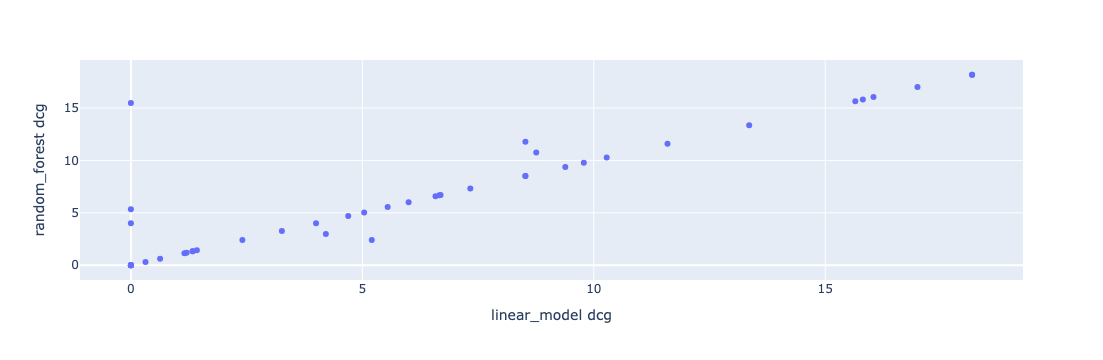

In [381]:
px.scatter(
    df_metrics_merged,
    x="linear_model dcg",
    y="random_forest dcg",
    hover_data=df_metrics_merged.columns,
)

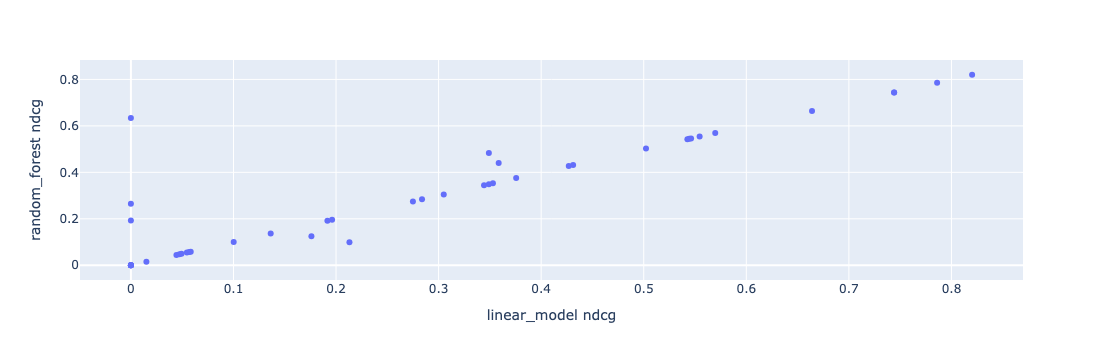

In [382]:
px.scatter(
    df_metrics_merged,
    x="linear_model ndcg",
    y="random_forest ndcg",
    hover_data=df_metrics_merged.columns,
)

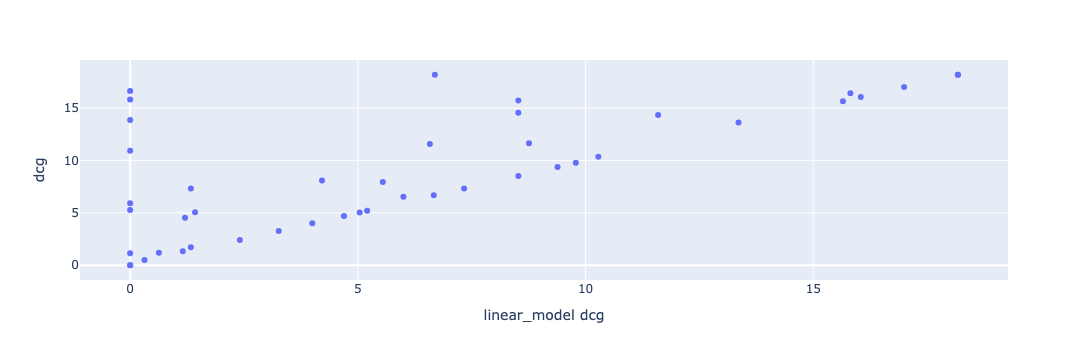

In [383]:
px.scatter(
    df_metrics_merged,
    x="linear_model dcg",
    y="dcg",
    hover_data=df_metrics_merged.columns,
)

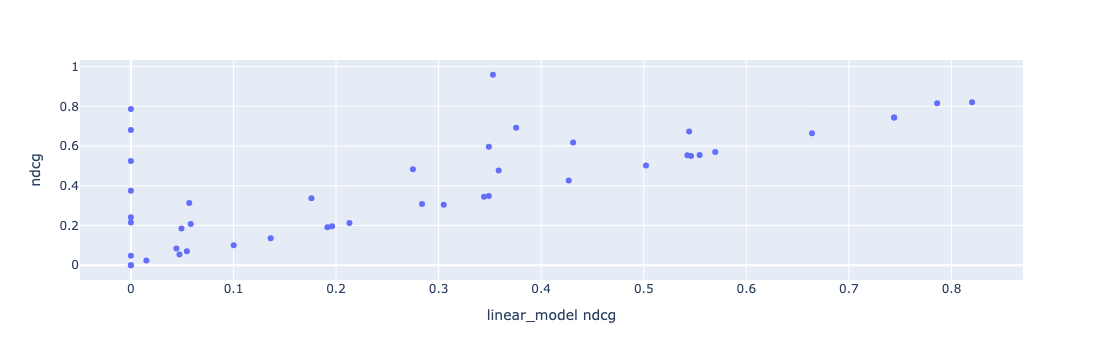

In [384]:
px.scatter(
    df_metrics_merged,
    x="linear_model ndcg",
    y="ndcg",
    hover_data=df_metrics_merged.columns,
)

In [385]:
df_metrics_merged['dcg_difference'] = df_metrics_merged['random_forest dcg'] - df_metrics_merged['linear_model dcg']

In [386]:
df_metrics_merged[['query', 'dcg_difference','random_forest dcg','linear_model dcg']].sort_values(by='dcg_difference').head(5)

,query,dcg_difference,random_forest dcg,linear_model dcg
14,golf sets for men left handed,-2.786001,2.418119,5.204120
16,heavy duty plastic folders with pockets,-1.227733,2.984566,4.212299
0,7 days without a pun makes one weak,0.000000,15.650518,15.650518
23,lights bulbs color changing,0.000000,0.000000,0.000000
24,mary meyer baby mat,0.000000,15.813858,15.813858


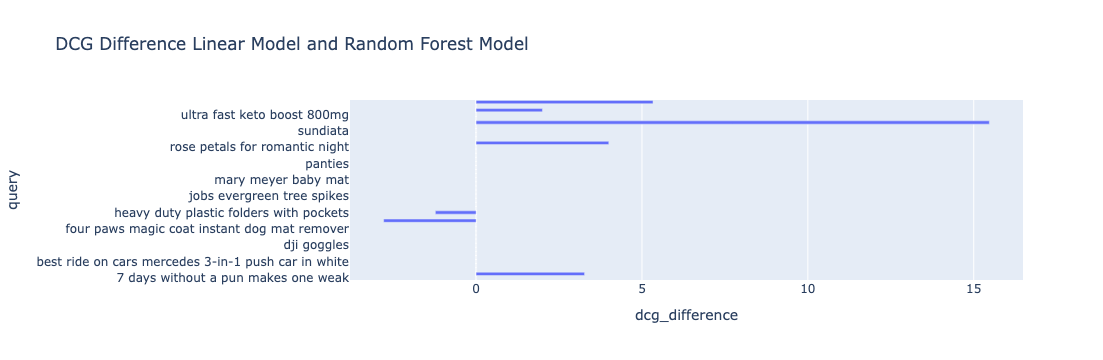

In [387]:
px.bar(df_metrics_merged, x="dcg_difference", y="query", orientation='h',
             hover_data=df_metrics_merged.columns,
             height=1000,
             title='DCG Difference Linear Model and Random Forest Model')

## Metrics per Pipeline from Hybrid Optimizer for Test Queries

We compare the metrics aggregated over 44 test queries and compared them to the metrics from all 220 queries above.

Let's do the comparison for the results of the 44 queries only.

In [411]:
df_hso_results = pd.read_csv('results_and_ratings.csv', index_col=[0])

In [412]:
df_hso_results.head(3)

,query_id,query_string,product_id,position,relevance,run,rating
0,0,$30 roblox gift card not digital,B00F4CF4PU,0,1.000000,min_maxarithmetic_mean0.0,NaN
1,0,$30 roblox gift card not digital,B07C438TMN,1,0.799684,min_maxarithmetic_mean0.0,NaN
2,0,$30 roblox gift card not digital,B00XJZHJCA,2,0.795128,min_maxarithmetic_mean0.0,NaN


In [413]:
df_test_data.head(3)

,query_string,ndcg,neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score,linear_model,random_forest
0,7 days without a pun makes one weak,0.664066,1.0,8,35,1,0,13,0.261906,2.187382,0.816212,0.714292,0.801477,0.435
1,american flag 5x8 outdoor made in usa,0.595807,0.3,7,37,1,0,8,0.913549,4.974668,0.755891,0.723251,0.741743,0.516
2,andis t edger,0.308602,1.0,3,13,0,0,2,0.086820,0.166090,0.578003,0.519416,0.735459,0.669


In [414]:
df_hso_results_fitlered = df_hso_results[df_hso_results['query_string'].isin(df_test_data['query_string'])]

In [415]:
df_hso_results_fitlered

,query_id,query_string,product_id,position,relevance,run,rating
900,9,7 days without a pun makes one weak,B07PCLLG2H,0,1.000000,min_maxarithmetic_mean0.0,3.0
901,9,7 days without a pun makes one weak,B07PY9SL52,1,0.948538,min_maxarithmetic_mean0.0,NaN
902,9,7 days without a pun makes one weak,B083Z9M4TR,2,0.919161,min_maxarithmetic_mean0.0,3.0
903,9,7 days without a pun makes one weak,B07PGBYSYD,3,0.912485,min_maxarithmetic_mean0.0,3.0
904,9,7 days without a pun makes one weak,B07RHGP8T8,4,0.912149,min_maxarithmetic_mean0.0,3.0
...,...,...,...,...,...,...,...
1451895,218,wowled,B07W6KQQ53,95,0.000000,l2geometric_mean1.0,NaN
1451896,218,wowled,B000QZYTU6,96,0.000000,l2geometric_mean1.0,NaN
1451897,218,wowled,B0818RWK73,97,0.000000,l2geometric_mean1.0,NaN
1451898,218,wowled,B07ND3XYWM,98,0.000000,l2geometric_mean1.0,NaN


In [418]:
df_metrics_hso_results_filtered = []
for m_name, m_function, ref_search in metrics:
    for (query_string, run), df_gr in df_hso_results_fitlered.groupby(["query_string", "run"]):
        metric = m_function(df_gr, reference=reference[query_string])
        df_metrics_hso_results_filtered.append(pd.DataFrame({
            "query": [query_string],
            "pipeline": [run],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics_hso_results_filtered = pd.concat(df_metrics_hso_results_filtered)

In [419]:
df_metrics_hso_results_filtered

,query,pipeline,metric,value
0,7 days without a pun makes one weak,l2arithmetic_mean0.0,dcg,15.650518
0,7 days without a pun makes one weak,l2arithmetic_mean0.1,dcg,15.650518
0,7 days without a pun makes one weak,l2arithmetic_mean0.2,dcg,15.650518
0,7 days without a pun makes one weak,l2arithmetic_mean0.3,dcg,15.650518
0,7 days without a pun makes one weak,l2arithmetic_mean0.4,dcg,15.650518
...,...,...,...,...
0,wowled,min_maxharmonic_mean0.6,ratio_of_ratings,0.300000
0,wowled,min_maxharmonic_mean0.7,ratio_of_ratings,0.300000
0,wowled,min_maxharmonic_mean0.8,ratio_of_ratings,0.300000
0,wowled,min_maxharmonic_mean0.9,ratio_of_ratings,0.300000


In [420]:
df_metrics_per_pipeline_hso = df_metrics_hso_results_filtered.pivot_table(index="pipeline", columns="metric", values="value", aggfunc=lambda x: x.mean().round(2))
df_metrics_per_pipeline_hso = df_metrics_per_pipeline_hso.reset_index()
df_metrics_per_pipeline_hso.head(4)

metric,pipeline,dcg,ndcg,prec@10,ratio_of_ratings
0,l2arithmetic_mean0.0,5.79,0.27,0.30,0.32
1,l2arithmetic_mean0.1,6.95,0.32,0.35,0.37
2,l2arithmetic_mean0.2,7.07,0.32,0.36,0.38
3,l2arithmetic_mean0.3,7.73,0.35,0.40,0.42


In [429]:
df_metrics_per_pipeline_hso.sort_values(by='ndcg', ascending=False).head(1)

metric,pipeline,dcg,ndcg,prec@10,ratio_of_ratings
29,l2harmonic_mean0.7,7.86,0.36,0.41,0.43


In [430]:
df_metrics_per_pipeline_hso.sort_values(by='dcg', ascending=False).head(1)

metric,pipeline,dcg,ndcg,prec@10,ratio_of_ratings
30,l2harmonic_mean0.8,7.97,0.36,0.42,0.44


In [431]:
df_metrics_per_pipeline_hso.sort_values(by='prec@10', ascending=False).head(1)

metric,pipeline,dcg,ndcg,prec@10,ratio_of_ratings
30,l2harmonic_mean0.8,7.97,0.36,0.42,0.44


In [425]:
df_metrics_per_pipeline

metric,model,dcg,ndcg,prec@10,ratio_of_ratings
0,linear_model,7.57,0.35,0.39,0.41
1,random_forest,7.82,0.36,0.41,0.43
